Imported Libraries

In [1]:
import os, dotenv, torch, random, pathlib
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import numpy as np
from PIL import Image
import torchvision.transforms.v2 as T
from tqdm import tqdm

In [2]:
def transform(image):
    return T.Compose([
        T.Resize((512, 512)),
        T.ToTensor()
    ])(image)

Define the dataset class

In [3]:
class COCOClassificationDataset(Dataset):
    def __init__(self, data_dir, ann_file, target_classes, transform=None):
        self.data_dir = data_dir
        self.coco = COCO(ann_file)
        self.transform = transform

        self.cat_ids = self.coco.getCatIds(catNms=target_classes)
        self.ids = []
        self.to_index = { cat_id: i for i, cat_id in enumerate(self.cat_ids) }

        for category in self.cat_ids:
            self.ids.extend(self.coco.getImgIds(catIds=category))

        self.ids = list(set(self.ids))

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]

        # load image
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.data_dir, img_info['file_name'])
        image = Image.open(img_path).convert('RGB')
        
        # Convert from polygon masks to pixel mask
        ann_ids = coco.getAnnIds(imgIds=img_id, catIds=self.cat_ids)
        anns = self.coco.loadAnns(ann_ids)
        anns = torch.tensor(list({self.to_index[ann['category_id']] for ann in anns}), dtype=torch.long)

        labels = torch.zeros(len(self.cat_ids), dtype=torch.float32)

        if anns.numel():
            labels[anns] = 1
        # apply transforms
        if self.transform:
            image = self.transform(image)

        return image, labels

Create the dataset but filter for people, cars, and horses, instead of using all of the dataset classes. Then visualize some random examples

In [4]:
dotenv.load_dotenv()

data_path = pathlib.Path(os.getenv("DATAPATH"))
train_path = data_path/'train2017'
train_ann_file = data_path/'annotations/instances_train2017.json'

val_path = data_path/'val2017'
val_ann_file = data_path/'annotations/instances_val2017.json'

targets = ['person', 'car', 'horse']

train_set = COCOClassificationDataset(
    data_dir=train_path,
    ann_file=train_ann_file, 
    transform=transform,
    target_classes=targets
)

print(f"Dataset has {len(train_set)} images.")


loading annotations into memory...
Done (t=3.21s)
creating index...
index created!
Dataset has 68732 images.


In [ ]:
class CNN(nn.Module):
    def __init__(self, categories):
        super().__init__()
        s = nn.Sequential

        self.contracting_layers = nn.ModuleList([
            s(
                nn.Conv2d(3, 64, 3, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, 3),
				nn.BatchNorm2d(64),
                nn.ReLU(inplace=True)
            ),
            s(
                nn.MaxPool2d(2),
                nn.Conv2d(64, 128, 3, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 128, 3),
				nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
            ),
            s(
                nn.MaxPool2d(2),
                nn.Conv2d(128, 256, 3),
				nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, 3),
				nn.BatchNorm2d(256),
                nn.ReLU(inplace=True)
            ),
            s(
                nn.MaxPool2d(2),
                nn.Conv2d(256, 512, 3),
				nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.Conv2d(512, 512, 3),
				nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Conv2d(512, categories, 3)
            )
        ])

        self.to_logits = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(1)
        )

    def forward(self, x):

        for layer in self.contracting_layers:
            x = layer(x)

        x = self.to_logits(x)
        
        return x

In [6]:
# Hyperparameters
MOMENTUM = 0.99
LEARNING_RATE = 1e-3
LEARNING_RATE = 0.001 
BATCH_SIZE = 16
NUM_EPOCHS = 10
NUM_WORKERS = 2 # set to 0 if model isn't training

In [7]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

val_set = COCOClassificationDataset(
    data_dir=val_path, 
    ann_file=val_ann_file, 
    transform=transform,
    target_classes=targets
)

val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Train size: {len(train_set)} | Val size: {len(val_set)}")

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
Train size: 68732 | Val size: 2904


Initialize weights and start training loop

Training with SGD (Momentum: 0.99) on cuda
Starting Training Loop...


Epoch 1/10 [Train]:   0%|          | 0/4296 [00:00<?, ?it/s]/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Epoch 1/10 [Train]: 100%|██████████| 4296/4296 [18:19<00:00,  3.91it/s, train_loss=0.143] 
/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will b

Epoch 1 Results: Train Loss: 0.3317 | Val Loss: 0.2927 | LR: 0.001000


Epoch 2/10 [Train]:   0%|          | 0/4296 [00:00<?, ?it/s]/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Epoch 2/10 [Train]: 100%|██████████| 4296/4296 [18:28<00:00,  3.88it/s, train_loss=0.136] 
/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will b

Epoch 2 Results: Train Loss: 0.2919 | Val Loss: 0.2876 | LR: 0.001000


Epoch 3/10 [Train]:   0%|          | 0/4296 [00:00<?, ?it/s]/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Epoch 3/10 [Train]: 100%|██████████| 4296/4296 [18:20<00:00,  3.90it/s, train_loss=0.143] 
/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will b

Epoch 3 Results: Train Loss: 0.2755 | Val Loss: 0.2698 | LR: 0.001000


Epoch 4/10 [Train]:   0%|          | 0/4296 [00:00<?, ?it/s]/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Epoch 4/10 [Train]: 100%|██████████| 4296/4296 [18:22<00:00,  3.90it/s, train_loss=0.239] 
/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will b

Epoch 4 Results: Train Loss: 0.2707 | Val Loss: 0.2698 | LR: 0.001000


Epoch 5/10 [Train]:   0%|          | 0/4296 [00:00<?, ?it/s]/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Epoch 5/10 [Train]: 100%|██████████| 4296/4296 [18:30<00:00,  3.87it/s, train_loss=0.401] 
/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will b

Epoch 5 Results: Train Loss: 0.2655 | Val Loss: 0.2913 | LR: 0.001000


Epoch 6/10 [Train]:   0%|          | 0/4296 [00:00<?, ?it/s]/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Epoch 6/10 [Train]: 100%|██████████| 4296/4296 [18:24<00:00,  3.89it/s, train_loss=0.328] 
/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will b

Epoch 6 Results: Train Loss: 0.2605 | Val Loss: 0.2579 | LR: 0.001000


Epoch 7/10 [Train]:   0%|          | 0/4296 [00:00<?, ?it/s]/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Epoch 7/10 [Train]: 100%|██████████| 4296/4296 [18:21<00:00,  3.90it/s, train_loss=0.212] 
/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will b

Epoch 7 Results: Train Loss: 0.2547 | Val Loss: 0.2503 | LR: 0.001000


Epoch 8/10 [Train]:   0%|          | 0/4296 [00:00<?, ?it/s]/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Epoch 8/10 [Train]: 100%|██████████| 4296/4296 [18:33<00:00,  3.86it/s, train_loss=0.39]  
/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will b

Epoch 8 Results: Train Loss: 0.2502 | Val Loss: 0.2480 | LR: 0.001000


Epoch 9/10 [Train]:   0%|          | 0/4296 [00:00<?, ?it/s]/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Epoch 9/10 [Train]: 100%|██████████| 4296/4296 [18:36<00:00,  3.85it/s, train_loss=0.217] 
/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will b

Epoch 9 Results: Train Loss: 0.2492 | Val Loss: 0.2545 | LR: 0.001000


Epoch 10/10 [Train]:   0%|          | 0/4296 [00:00<?, ?it/s]/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Epoch 10/10 [Train]: 100%|██████████| 4296/4296 [18:36<00:00,  3.85it/s, train_loss=0.772] 
/home/brambles/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will

Epoch 10 Results: Train Loss: 0.2450 | Val Loss: 0.2647 | LR: 0.001000
Training Complete.


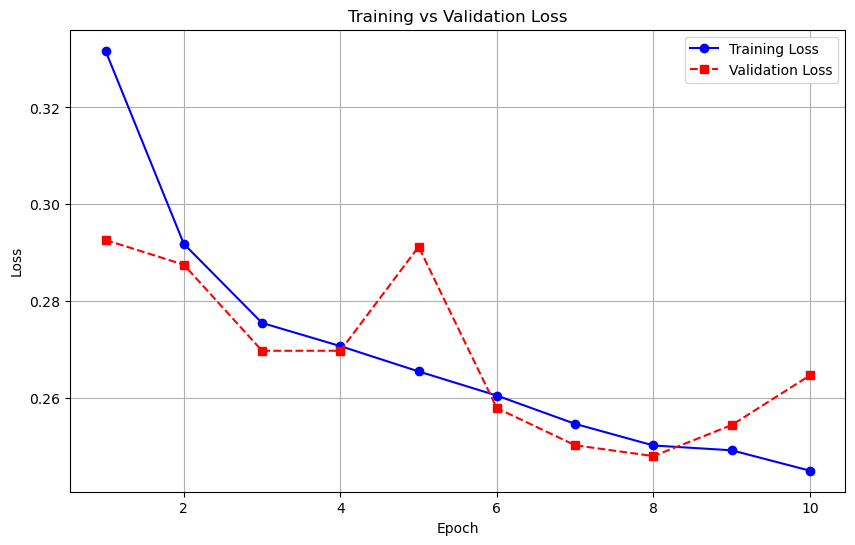

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training with SGD (Momentum: {MOMENTUM}) on {device}")

model = CNN(len(targets)).to(device)

# "He" weight initialization
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(weights_init)

loss_func = nn.BCEWithLogitsLoss()

# Implements SGD with the paper's momentum
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# High momentum SGD can sometimes overshoot, so a scheduler helps it settle.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

# Training and validiation loop
train_loss_history = []
val_loss_history = []

print("Starting Training Loop...")

for epoch in range(NUM_EPOCHS):
    model.train()
    running_train_loss = 0
    loop = tqdm(train_loader, leave=True, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)
        
        predictions = model(images)
        loss = loss_func(predictions, labels)
        running_train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loop.set_postfix(train_loss=loss.item())
    
    avg_train_loss = running_train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0
    
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images = val_images.to(device)
            val_masks = val_masks.to(device)
            
            val_preds = model(val_images)
            v_loss = loss_func(val_preds, val_masks)
            
            running_val_loss += v_loss.item()
            
    avg_val_loss = running_val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)
    
    # Stepping the scheduler based on validation loss
    scheduler.step(avg_val_loss)
    
    print(f"Epoch {epoch+1} Results: Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Saving checkpoint
    torch.save(model.state_dict(), f'unet_sgd_epoch_{epoch+1}.pth')

print("Training Complete.")

# visualization bit
plt.figure(figsize=(10, 6))
epochs_range = range(1, NUM_EPOCHS + 1)

plt.plot(epochs_range, train_loss_history, marker='o', color='blue', label='Training Loss')
plt.plot(epochs_range, val_loss_history, marker='s', color='red', linestyle='--', label='Validation Loss')

plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Path to your best saved model
MODEL_PATH = 'unet_sgd_epoch_10.pth' # Or 'best_model.pth' if you implemented saving the best

def load_random_test_images(img_dir, num_images=3):
    """
    Picks random images from the directory and prepares them for the model.
    """
    all_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))]
    
    if len(all_files) == 0:
        raise ValueError(f"No images found in {img_dir}")
        
    selected_files = random.sample(all_files, num_images)
    
    loaded_data = []
    
    for fname in selected_files:
        path = os.path.join(img_dir, fname)
        original_image = Image.open(path).convert('RGB')
        
        # Preprocess for Model (Resize & Tensor)
        # Note: We resize to 256x256 because U-Net expects a consistent input size 
        # that matches training.
        input_image = TF.resize(original_image, (256, 256))
        input_tensor = TF.to_tensor(input_image)
        
        loaded_data.append({
            'fname': fname,
            'original': original_image,
            'tensor': input_tensor
        })
        
    return loaded_data

# 3. LOAD MODEL
# =============
print(f"Loading model from {MODEL_PATH}...")
# Initialize the model architecture (Must match training!)
model = UNet(n_channels=3, n_classes=2).to(DEVICE)

# Load weights
# map_location ensures it loads on CPU if CUDA is not available
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval() # Important: set to eval mode!

# 4. RUN INFERENCE & VISUALIZE
# ============================
print(f"Selecting 3 random images from {TEST_IMG_DIR}...")

try:
    test_samples = load_random_test_images(TEST_IMG_DIR, num_images=2)
    
    # Create Plot
    fig, axes = plt.subplots(2, 2, figsize=(10, 15))
    
    with torch.no_grad():
        for i, sample in enumerate(test_samples):
            # Prepare batch of size 1
            input_batch = sample['tensor'].unsqueeze(0).to(DEVICE)
            
            # Forward Pass
            logits = model(input_batch)
            
            # Get Predictions (Argmax)
            # Logits shape: [1, 2, 256, 256] -> Preds shape: [256, 256]
            preds = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()
            
            # --- PLOTTING ---
            
            # Column 1: Input Image
            # We show the resized version effectively used by the network
            input_display = sample['tensor'].permute(1, 2, 0).numpy()
            axes[i][0].imshow(input_display)
            axes[i][0].set_title(f"Test Image: {sample['fname']}")
            axes[i][0].axis('off')
            
            # Column 2: Predicted Mask
            # We use a color map (like 'jet' or 'gray') to visualize the classes
            # Class 0 = Background (Purple/Black), Class 1 = Person (Yellow/White)
            axes[i][1].imshow(preds, cmap='jet', interpolation='nearest')
            axes[i][1].set_title("Predicted Segmentation")
            axes[i][1].axis('off')
            
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"Error: Could not find directory {TEST_IMG_DIR}. Please check the path.")
except Exception as e:
    print(f"An error occurred: {e}")

Loading model from unet_sgd_epoch_10.pth...


TypeError: UNet.__init__() got an unexpected keyword argument 'n_channels'